In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [41]:
df = pd.read_csv('carclaims.csv')
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

No     14497
Yes      923
Name: FraudFound, dtype: int64


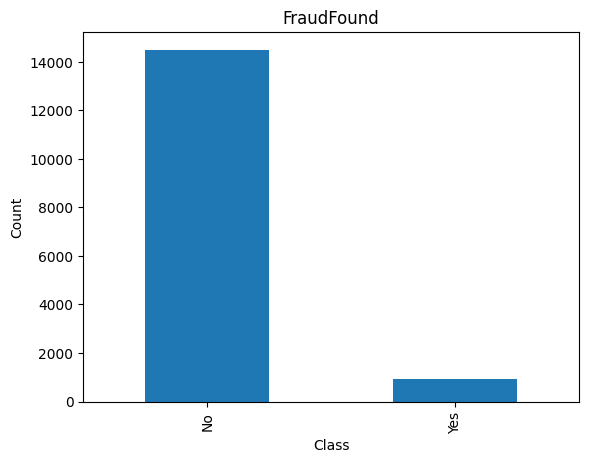

In [42]:
y = df['FraudFound']
X = df.drop(['FraudFound'], axis=1)

counts = y.value_counts()
print(counts)

counts.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('FraudFound')

plt.show()

In [43]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

X = one_hot_encoder.fit_transform(X)
scaler = MinMaxScaler() #StandardScaler()
X = scaler.fit_transform(X)



## Train imbalance un/aware models and do imbalance un/aware evaluation 

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

accuracy: 0.74 (+/- 0.03)
balanced_accuracy: 0.57 (+/- 0.06)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


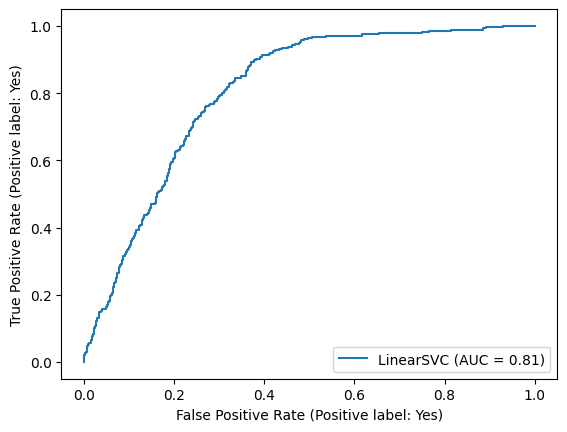

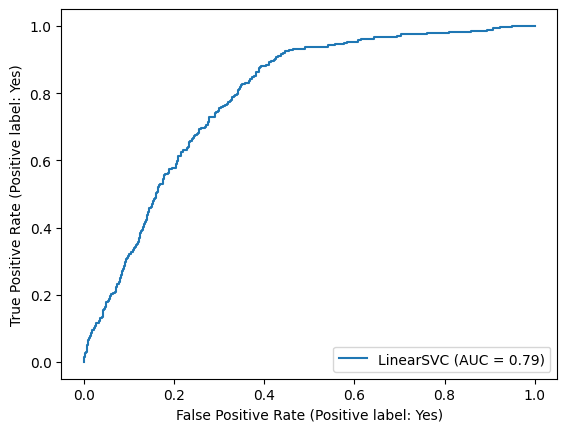

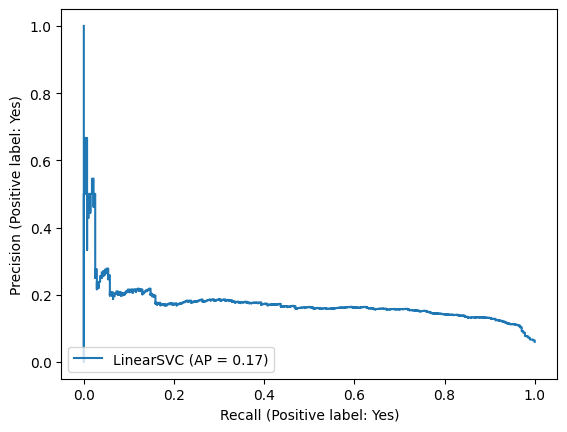

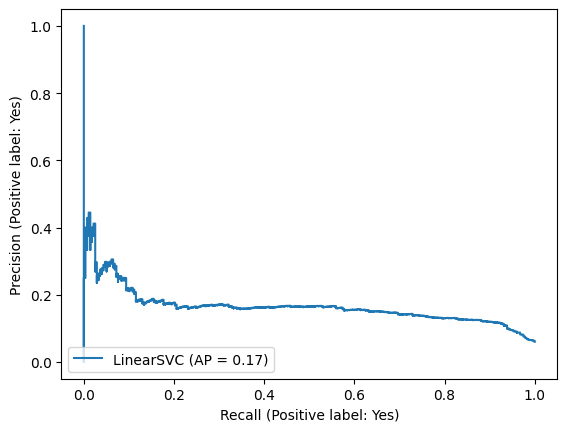

In [22]:
from sklearn.svm import LinearSVC
#from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

clf1 = LinearSVC()
clf2 = LinearSVC(class_weight="balanced") 

scoring = ['accuracy', 'balanced_accuracy']

scores = cross_validate(clf1, X, y, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
    print("%s: %.2f (+/- %.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))

scores = cross_validate(clf2, X, y, scoring=scoring, cv=10, return_train_score=False)
for s in scoring:
    print("%s: %.2f (+/- %.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf1, X_test, y_test)
RocCurveDisplay.from_estimator(clf2, X_test, y_test)
PrecisionRecallDisplay.from_estimator(clf1, X_test, y_test)
PrecisionRecallDisplay.from_estimator(clf2, X_test, y_test)

# Sampling based approaches

## Synthetic oversampling 
(Yπερδειγματοληψία με κατασκευή συνθετικών δεδομένων)

In [8]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

algs = []
svm = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([svm, "Linear SVM"])
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])


for c, d in algs:
    print("\n" + d)
    # Create a pipeline
    pipeline = make_pipeline(c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

    # Create a pipeline
    pipeline2 = make_pipeline(SMOTE(random_state=0, k_neighbors=5),c)
    pipeline2.fit(X_train, y_train)

    # Classify and report the results
    print("with SMOTE")
    print(classification_report_imbalanced(y_test, pipeline2.predict(X_test)))



Linear SVM
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.08      0.01      4349
        Yes       0.29      0.01      1.00      0.01      0.08      0.01       277

avg / total       0.90      0.94      0.07      0.91      0.08      0.01      4626

with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

         No       0.99      0.64      0.85      0.78      0.74      0.54      4349
        Yes       0.13      0.85      0.64      0.23      0.74      0.56       277

avg / total       0.93      0.66      0.84      0.75      0.74      0.54      4626


Random Forest
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.10      0.01      4349
        Yes       0.60      0.01      1.00      0.02      0.10      0.01       277

avg / total       0.92      0.94      0.0

'\n# Create a pipeline\npipeline = make_pipeline(LinearSVC(loss=\'squared_hinge\', random_state=0, class_weight=\'balanced\'))\npipeline.fit(X_train, y_train)\n\n# Classify and report the results\nprint("Linear SVM with balanced weights")\nprint(classification_report_imbalanced(y_test, pipeline.predict(X_test)))\n'

## Easy ensemble
(είτε συνδυάζει υπέρ και υπόδειγματοληψία είτε χρησιμοποιεί κάποιο σύνολο μοντέλων)

### SVM

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter


scoring = ['accuracy', 'balanced_accuracy']

algs = []
lsvc = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([lsvc, "Linear SVM"])
lsvc2 = LinearSVC(loss='squared_hinge', random_state=0, class_weight='balanced')
algs.append([lsvc2, "Linear SVM with balanced class weights"])
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])

for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))


Linear SVM
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)

Linear SVM with balanced class weights
accuracy: 0.74 (+/- 0.03)
balanced_accuracy: 0.56 (+/- 0.06)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


### Random Forest

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter


scoring = ['accuracy', 'balanced_accuracy']

algs = []
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
rf2 = RandomForestClassifier(criterion='gini', random_state=0, class_weight='balanced')
algs.append([rf2, "Random Forest with balanced class weights"])
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])

for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))        


Random Forest
accuracy: 0.93 (+/- 0.02)
balanced_accuracy: 0.51 (+/- 0.03)

Random Forest with balanced class weights
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


### Naive Bayes

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter


scoring = ['accuracy', 'balanced_accuracy']

algs = []
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])
cnb = ComplementNB(force_alpha=True)
algs.append([cnb, "Complement Naive Bayes"]) # particularly suited for imbalanced data sets
ee = EasyEnsembleClassifier(random_state=0)
algs.append([ee, "easy ensemble"])


for c, d in algs:
    print("\n" + d)
    scores = cross_validate(c, X, y, scoring=scoring, cv=10, return_train_score=False)
    for s in scoring:
        print("%s: %0.2f (+/- %0.2f)" % (s, scores["test_" + s].mean(), scores["test_" + s].std()))       


Naive Bayes
accuracy: 0.10 (+/- 0.01)
balanced_accuracy: 0.51 (+/- 0.00)

Complement Naive Bayes
accuracy: 0.62 (+/- 0.02)
balanced_accuracy: 0.65 (+/- 0.04)

easy ensemble
accuracy: 0.60 (+/- 0.20)
balanced_accuracy: 0.61 (+/- 0.09)


## Cluster-Based Sampling
(Yποδειγματοληψίας με ομαδοποίηση)

In [21]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

undersampler = ClusterCentroids()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

algs = []
svm = LinearSVC(loss='squared_hinge', random_state=0)
algs.append([svm, "Linear SVM"])
rf = RandomForestClassifier(criterion='gini', random_state=0)
algs.append([rf, "Random Forest"])
nb = GaussianNB()
algs.append([nb, "Naive Bayes"])


for c, d in algs:
    print("\n" + d)
    # Create a pipeline
    pipeline = make_pipeline(c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

    # Create a pipeline
    pipeline = make_pipeline(undersampler,c)
    pipeline.fit(X_train, y_train)

    # Classify and report the results
    print("with Cluster Centroids Undersampling")
    print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))



Linear SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.08      0.01      4349
        Yes       0.29      0.01      1.00      0.01      0.08      0.01       277

avg / total       0.90      0.94      0.07      0.91      0.08      0.01      4626



/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


with Cluster Centroids Undersampling
                   pre       rec       spe        f1       geo       iba       sup

         No       0.99      0.59      0.91      0.74      0.73      0.52      4349
        Yes       0.12      0.91      0.59      0.22      0.73      0.56       277

avg / total       0.94      0.61      0.89      0.71      0.73      0.52      4626


Random Forest
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.10      0.01      4349
        Yes       0.60      0.01      1.00      0.02      0.10      0.01       277

avg / total       0.92      0.94      0.07      0.91      0.10      0.01      4626



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


with Cluster Centroids Undersampling
                   pre       rec       spe        f1       geo       iba       sup

         No       1.00      0.13      1.00      0.22      0.36      0.12      4349
        Yes       0.07      1.00      0.13      0.13      0.36      0.14       277

avg / total       0.94      0.18      0.95      0.22      0.36      0.12      4626


Naive Bayes
                   pre       rec       spe        f1       geo       iba       sup

         No       0.96      0.04      0.97      0.08      0.21      0.04      4349
        Yes       0.06      0.97      0.04      0.11      0.21      0.05       277

avg / total       0.91      0.10      0.92      0.09      0.21      0.04      4626



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


with Cluster Centroids Undersampling
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      0.04      0.96      0.08      0.20      0.04      4349
        Yes       0.06      0.96      0.04      0.11      0.20      0.05       277

avg / total       0.89      0.10      0.90      0.09      0.20      0.04      4626



## NearMiss

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced # focus on geo
from imblearn.ensemble import EasyEnsembleClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Create a pipeline
pipeline = make_pipeline(LinearSVC(loss='squared_hinge', random_state=0))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Linear SVM")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

# Create a pipeline
pipeline = make_pipeline(LinearSVC(loss='squared_hinge', random_state=0, class_weight='balanced'))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Linear SVM with balanced class weights")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=1),
                         LinearSVC(loss='squared_hinge', random_state=0))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Linear SVM with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2),
                        LinearSVC(loss='squared_hinge', random_state=0))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Linear SVM with near miss 2")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

# Create a pipeline
print("Linear SVM with near miss 3") # See issue in GitHub
pipeline = make_pipeline(NearMiss(version=3, n_neighbors_ver3=3),
                         LinearSVC(loss='squared_hinge', random_state=0))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM
                   pre       rec       spe        f1       geo       iba       sup

         No       0.94      1.00      0.01      0.97      0.08      0.01      4349
        Yes       0.29      0.01      1.00      0.01      0.08      0.01       277

avg / total       0.90      0.94      0.07      0.91      0.08      0.01      4626



/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM with balanced class weights
                   pre       rec       spe        f1       geo       iba       sup

         No       0.97      0.76      0.67      0.86      0.71      0.52      4349
        Yes       0.15      0.67      0.76      0.25      0.71      0.51       277

avg / total       0.92      0.76      0.67      0.82      0.71      0.51      4626



/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

         No       0.97      0.49      0.74      0.65      0.60      0.35      4349
        Yes       0.08      0.74      0.49      0.15      0.60      0.37       277

avg / total       0.91      0.50      0.72      0.62      0.60      0.35      4626



/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM with near miss 2
                   pre       rec       spe        f1       geo       iba       sup

         No       0.97      0.29      0.84      0.45      0.50      0.23      4349
        Yes       0.07      0.84      0.29      0.13      0.50      0.26       277

avg / total       0.91      0.32      0.81      0.43      0.50      0.23      4626

Linear SVM with near miss 3
                   pre       rec       spe        f1       geo       iba       sup

         No       0.98      0.62      0.79      0.76      0.70      0.48      4349
        Yes       0.12      0.79      0.62      0.20      0.70      0.49       277

avg / total       0.93      0.63      0.78      0.72      0.70      0.48      4626



/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
